In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/japanese-fakenews-dataset/fakenews.csv


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Import basic libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv('/kaggle/input/japanese-fakenews-dataset/fakenews.csv')
df.head()

,id,context,isfake,nchar_real,nchar_fake
0,000128042337,朝日新聞など各社の報道によれば、宅配便最大手「ヤマト運輸」が日本郵政公社を相手取り、大手コン...,0,541,0
1,00012b7a8314,11月5日の各社報道によると、諫早湾干拓事業は諫早海人（諫早湾の「海」）に囲まれる大洋に位置...,2,0,385
2,0005fb48880b,産経新聞、中日新聞によると、2004年から2005年まで、この大会による3年おきの開催を、2...,2,0,255
3,00087f9e14ab,開催地のリオデジャネイロ市に対して、大会期間中のリオデジャネイロオリンピックに関する公式発表...,1,435,218
4,000c9ac3d552,毎日新聞・時事通信によると、2006年2月13日には、グッドウィル・グッゲンハイム・アン・ハ...,2,0,248


In [5]:
df.columns

Index(['id', 'context', 'isfake', 'nchar_real', 'nchar_fake'], dtype='object')

In [6]:
# Check for nulls and types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13040 entries, 0 to 13039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          13040 non-null  object
 1   context     13040 non-null  object
 2   isfake      13040 non-null  int64 
 3   nchar_real  13040 non-null  int64 
 4   nchar_fake  13040 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 509.5+ KB


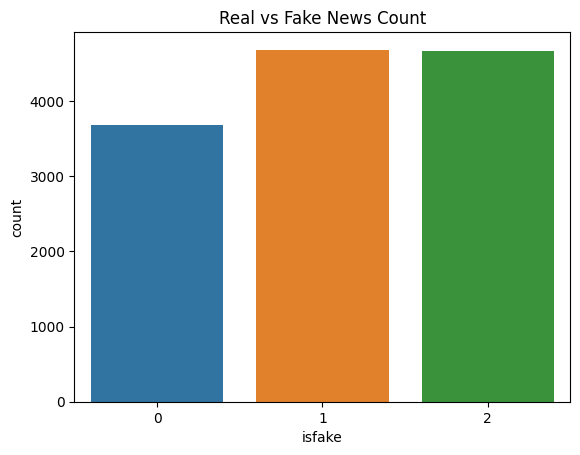

In [7]:
# Visualize the distribution of real vs fake
sns.countplot(data=df, x='isfake')
plt.title('Real vs Fake News Count')
plt.show()

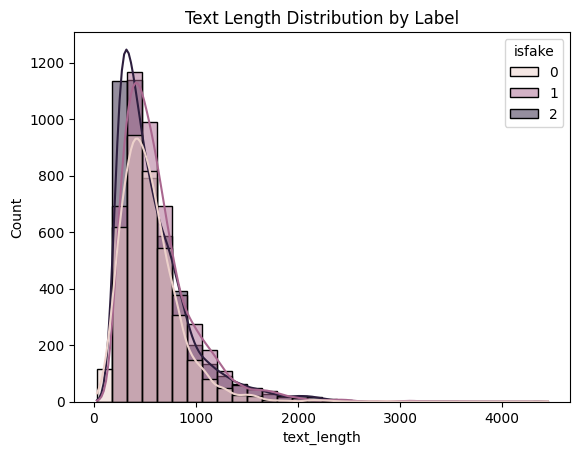

In [8]:
# Check text lengths
df['text_length'] = df['context'].apply(len)

# Visualize text length by class
sns.histplot(data=df, x='text_length', hue='isfake', bins=30, kde=True)
plt.title('Text Length Distribution by Label')
plt.show()

In [9]:
# Import preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Split data
X = df['context']
y = df['isfake']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# TF-IDF (text to numbers)
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [12]:
# Import and train XGBoost
from xgboost import XGBClassifier
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train_tfidf, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [13]:
# Accuracy and classification report
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.5996932515337423
              precision    recall  f1-score   support

           0       0.69      0.55      0.61       766
           1       0.56      0.43      0.48       928
           2       0.58      0.82      0.68       914

    accuracy                           0.60      2608
   macro avg       0.61      0.60      0.59      2608
weighted avg       0.60      0.60      0.59      2608



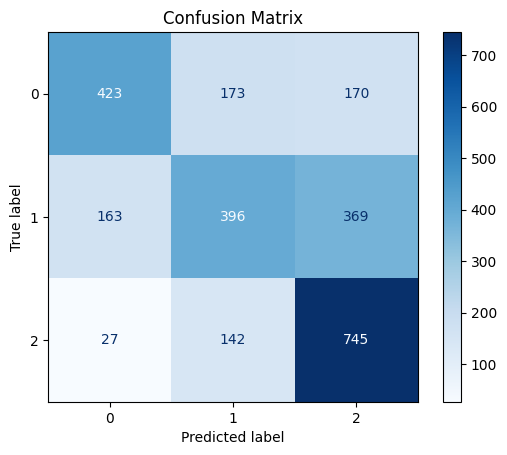

In [14]:
# Confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(model, X_test_tfidf, y_test, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()